<a href="https://colab.research.google.com/github/NMashalov/2023_OpenMipt_course/blob/main/lesson4/seminar4-rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Семинар 4


## Рекуррентные нейронные сети и одномерные свёртки в `pytorch`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
from skimage import io

sns.set(palette='Set2', font_scale=1.3)
from warnings import filterwarnings
filterwarnings('ignore')

### 1. Параметры и применение рекуррентных сетей

Перед тем, как использовать нейронные сети, вспомним, какие гиперпараметры у них есть и как следует их использовать. На лекции вы рассмотрели три вида рекурентных сетей:

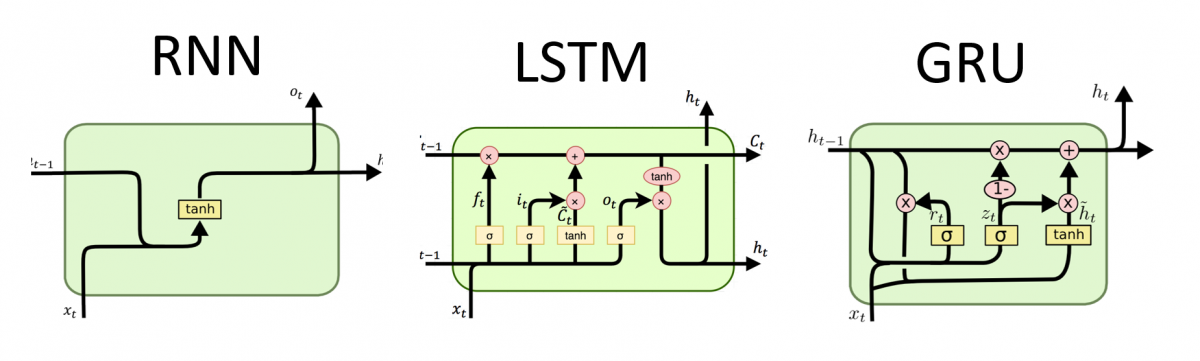

Остановимся на каждой их них подробнее.

### 1.1 Vanilla RNN

Клетка Vanilla RNN принимает на вход очередной элемент $x_t$ и предыдущее скрытое состояние $h_{t-1}$, а выдаёт новое скрытое состояние $h_t$.

Преобразование происходит по формуле:

$$h_t = \sigma(U_hx_t + V_hh_{t-1} + b_h),$$

где
* $x_{t}$ &mdash; вектор входных параметров размерности `(input_size, )`;

* $h_t, b_h$ &mdash; скрытое состояние и свободный член, векторы размерности `(hidden_size, )`;

* $U_h$ и $V_h$ &mdash; матрицы весов с размерами `(hidden_size, input_size)` и `(hidden_size, hidden_size)` соответственно.

$U_h, V_h, b_h$ &mdash; обучаемые параметры RNN-клетки, а `hidden_size`, `input_size` &mdash; гиперпараметры.

Если же мы хотим решать задачу классификации, то мы можем применить линейный слой с функций softmax к скрытому состоянию и получить предсказание вероятности:
$$o_t = \sigma(W_o h_t + b_o).$$

В модуле `torch.nn` клетка Vanilla RNN представлена классом `torch.nn.RNNCell`. Его можно инициализировать следующим образом:

`torch.nn.RNNCell(input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'tanh')`.

Класс `RNNCell` возвращает скрытое состояние $h_t$.

Самый простой пример применения клетки RNN:

In [5]:
rnn = nn.RNNCell(input_size=10, hidden_size=20)
input = torch.randn(3, 10)  # батч из 3-х векторов размерности 10
hx = torch.randn(3, 20)     # батч из 3-х векторов размерности 20
                            # батч != последовательность
hx = rnn(input, hx)
hx.shape

torch.Size([3, 20])

Если на вход не подается `hx` (например, для первого элемента последовательности), то вектор скрытых состояний считается нулевым:

In [6]:
hx = rnn(input)
hx.shape

torch.Size([3, 20])

**Задание.** Напишите функцию для последовательного применения клетки RNNCell к последовательности векторов.

In [14]:
def aply_rnncell_to_seq(rnn_cell, input, hx=None):
    """
    rnn_cell - клетка rnn
    input - входной тензор размерности (seq_len, batch_size, input_size)
    hx - начальный вектор скрытого состяния

    возвращает: последнее скрытое состояние для каждого элемента батча
    """
    # ваш код
    h_n = rnn_cell(input[0],hx)
    for i in range(1,input.size(0)):
        h_n = rnn_cell(input[i],h_n)
    return h_n

In [15]:
input = torch.randn(15, 3, 10)
rnn = nn.RNNCell(input_size=10, hidden_size=20)
hx = torch.randn(3, 20)

print(aply_rnncell_to_seq(rnn, input, hx).shape)
print(aply_rnncell_to_seq(rnn, input).shape)

torch.Size([3, 20])
torch.Size([3, 20])


Однако, работать с циклами для этих целей совсем неудобно. А если мы хотим использовать ещё многослойные `RNN`, то неудобство возрастает. Разумеется, в pytorch существует класс `RNN`. Он имеет следующий параметры

1. `input_size` &mdash;  размерность входного вектора $x_t$, т. е. количество признаков;

2. `hidden_size` &mdash;  размер скрытого состояния;

3. `num_layers` &mdash;  число рекуррентных слоёв;

4. `nonlinearity` &mdash;  функция активации &mdash;  `'tanh'` или `'relu'`, по умолчанию: `'tanh'`;

5. `bias` &mdash;  если установлен в `False`, то $b\_h$ устанавливаются равными 0 и не обучается, по умолчанию: `True`;

6. `batch_first` &mdash;  если `True`, то входные и выходные тензоры имеют размерность `(batch_size, seq_len, feature)`, иначе `(seq_len, batch_size, feature)`, по умолчанию: `False`;

7. `dropout` &mdash;  вероятность отключения каждого нейрона при dropout, по умолчанию: `0`;

8. `bidirectional` &mdash;  использовать ли двунаправленную сеть.

\\

Объект класса принимает на вход `input` и `h_0`:
* `input` &mdash; тензор, содержащий последовательность векторов из признаков. Имеет размерность `(batch_size, seq_len, input_size)`, если `batch_first = True`.
* `h_0` &mdash;  скрытые состояния на последний момент времени со всех слоев и со всех направлений (forward и backward); Имеет размерность `(batch_size, num_directions * num_layers, hidden_size)`.

\\

`RNN` возвращает `output` и `h_n`.

* `output` &mdash;  скрытые состояния последнего слоя для всех моментов времени t. В случае, `bidirectional`=True, то то же самое и для обратного прохода.   Размерность `output`: `(batch_size, seq_len, num_directions * hidden_size)`, если `batch_first = True`.
* `h_n` &mdash;  скрытые состояния на последний момент времени со всех слоев и со всех направлений (forward и backward);
В случае, если слой один и RNN однонаправленная, то это просто последнее скрытое состояние. Размерность `h_n`:  `(batch_size, num_layers * num_directions, hidden_size)`.

В случае если батч имеет размер 1, размерность `batch_size` отбрасывается.

Посмотрим на этот класс в коде (**заполните пропуски**):

In [16]:
batch_size = 10
input_size = 10
num_layers = 5
hidden_size = 20

# длина последовательности
seq_len = 128

rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

input  = torch.randn(batch_size, seq_len,    input_size)
h0     = torch.randn(num_layers, batch_size, hidden_size)   # параметр first_batch на h_0 не действует

output, hn = rnn(input, h0)
print(output.shape, hn.shape)

torch.Size([10, 128, 20]) torch.Size([5, 10, 20])


Объясните, какие размерности чему соответствуют.

**Ответ:**

### 1.2 LSTM

Как выглядит LSTM и какие у неё обучаемые параметры, было рассказано на лекции.
Устройство LSTM в pytorch аналогично Vanilla RNN. Основное отличие в параметрах &mdash; скрытое состояние представляет собой кортеж из двух векторов $(h_t, c_t)$.

**Задание.** По аналогии с `torch.nn.RNN` создайте объект класса `torch.nn.LSTM`.



In [19]:
lstm = nn.LSTM(
    input_size=20,
    hidden_size=50,
    num_layers=2,
    batch_first=True
) # ваш код

input = torch.randn(32,128,20) # ваш код
h_0 = torch.randn(32,50)# ваш код
c_0 = torch.randn(32,50)# ваш код

output, (hn, cn) = lstm(input)# ваш код
print(output.shape, hn.shape, cn.shape)

torch.Size([32, 128, 50]) torch.Size([2, 32, 50]) torch.Size([2, 32, 50])


### 1.3 GRU

Наборы параметров классов `GRUCell` и `GRU` и размерности возвращаемых тензоров совпадают соответсвенно с параметрами `RNNCell` и `RNN`.


In [20]:
gru = nn.GRU(
    input_size=20,
    hidden_size=50,
    num_layers=2,
    batch_first=True
) # ваш код

input = torch.randn(32,128,20) # ваш код
h_0 = torch.randn(32,50)# ваш код

output, h_n = gru(input)# ваш код
print(output.shape, hn.shape, cn.shape)

torch.Size([32, 128, 50]) torch.Size([2, 32, 50]) torch.Size([2, 32, 50])
